# Network Science Final Project

## 1. Data preprocessing

### 1.1 import data

In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import re
import warnings
from os import path
warnings.simplefilter('ignore')

In [2]:
# import dat files as dataframes
data_dir_of = path.join("data", "openFlights_airline")
data_dir_lsv = path.join("data", "lsv_airlines")

df_routes = pd.read_table(path.join(data_dir_of, "routes.dat.txt"), sep=",", header=None )
df_airline = pd.read_table(path.join(data_dir_of, "airlines.dat.txt"), sep=",", header=None )
df_planes = pd.read_table(path.join(data_dir_of, "planes.dat.txt"), sep=",", header=None )
df_airports = pd.read_table(path.join(data_dir_of, "airports.dat.txt"), sep=",", header=None )

# df_airports provides info about airports in df_routes
# however, not all the airports in routes are cover by df_airports
# here we import another dataset to increase coverage of the airports
df_airports2 = pd.read_csv(path.join(data_dir_lsv, "airports.txt"),sep=";", header = None)


print(f"df_routes is in the shape of {df_routes.shape}")
df_routes.head(5)

df_routes is in the shape of (67663, 9)


,0,1,2,3,4,5,6,7,8
0,2B,410,AER,2965,KZN,2990,NaN,0,CR2
1,2B,410,ASF,2966,KZN,2990,NaN,0,CR2
2,2B,410,ASF,2966,MRV,2962,NaN,0,CR2
3,2B,410,CEK,2968,KZN,2990,NaN,0,CR2
4,2B,410,CEK,2968,OVB,4078,NaN,0,CR2


In [3]:
# set the correct column names according to the information from the data source
df_routes.columns =['code','ID','Source_airport','Source_airport_ID','Des_airport','Des_airport_ID','Codeshare','Stops','Equipment']
df_airline.columns =['Airline ID','Name','Alias','IATA','ICAO','Callsign','Country','Active']
df_planes.columns =['name','iso_code','dafif_code']
df_airports.columns =['Airport ID','Name','City','Country','IATA','ICAO','Latitude','Longitude','Altitude','Timezone','DST','Tz_database_time','Type','Source']
df_airports2.columns =['Name','City','Country','IATA','ICAO','Latitude','Longitude','Altitude','Timezone','DST']
df_routes.head()

,code,ID,Source_airport,Source_airport_ID,Des_airport,Des_airport_ID,Codeshare,Stops,Equipment
0,2B,410,AER,2965,KZN,2990,NaN,0,CR2
1,2B,410,ASF,2966,KZN,2990,NaN,0,CR2
2,2B,410,ASF,2966,MRV,2962,NaN,0,CR2
3,2B,410,CEK,2968,KZN,2990,NaN,0,CR2
4,2B,410,CEK,2968,OVB,4078,NaN,0,CR2


In [4]:
# remove not-useful attributes in df_routes
if 'Codeshare' in df_routes:
    df_routes = df_routes.drop('Codeshare', axis=1) 
if 'Stops' in df_routes:
    df_routes = df_routes.drop('Stops', axis=1) 
if 'Equipment' in df_routes:
    df_routes = df_routes.drop('Equipment', axis=1) 
    
    
# remove not-useful attributes in df_airports
if 'Altitude' in df_airports:
    df_airports = df_airports.drop('Altitude', axis=1) 
if 'Timezone' in df_airports:
    df_airports = df_airports.drop('Timezone', axis=1) 
if 'DST' in df_airports:
    df_airports = df_airports.drop('DST', axis=1) 
if 'Tz_database_time' in df_airports:
    df_airports = df_airports.drop('Tz_database_time', axis=1) 
if 'Type' in df_airports:
    df_airports = df_airports.drop('Type', axis=1) 
if 'Source' in df_airports:
    df_airports = df_airports.drop('Source', axis=1) 
if 'Airport ID' in df_airports:
    df_airports = df_airports.drop('Airport ID', axis=1) 

    	
    
# remove not-useful attributes in df_airports2
if 'Altitude' in df_airports2:
    df_airports2 = df_airports2.drop('Altitude', axis=1) 
if 'Timezone' in df_airports2:
    df_airports2 = df_airports2.drop('Timezone', axis=1) 
if 'DST' in df_airports2:
    df_airports2 = df_airports2.drop('DST', axis=1) 

### 1.2 clean NaN values

In [5]:
# check for NaN values df_routes
df_routes[df_routes.isna().any(axis=1)]

,code,ID,Source_airport,Source_airport_ID,Des_airport,Des_airport_ID


There are no NaN in df_routes, clear and great.

In [6]:
# check for NaN values in df_airports
print(f"The shape of the missing values in df_airports:{df_airports[df_airports.isna().any(axis=1)].shape}")
df_airports[df_airports.isna().any(axis=1)].head(10)

The shape of the missing values in df_airports:(49, 7)


,Name,City,Country,IATA,ICAO,Latitude,Longitude
7031,Minsk Mazowiecki Military Air Base,NaN,Poland,\N,EPMM,52.195499,21.655899
7032,Powidz Military Air Base,NaN,Poland,\N,EPPW,52.379398,17.853901
7137,King Salman Abdulaziz Airport,NaN,Saudi Arabia,DWD,OEDM,24.449900,44.121201
7138,King Khaled Air Base,NaN,Saudi Arabia,KMX,OEKM,18.297300,42.803501
7158,Asahikawa Airfield,NaN,Japan,\N,RJCA,43.794734,142.365432
7160,Utsunomiya Airport,NaN,Japan,\N,RJTU,36.514500,139.871010
7161,Jungwon Air Base/Chungju Airport,NaN,South Korea,\N,RKTI,37.030240,127.886353
7164,Bislig Airport,NaN,Philippines,BPH,RPMF,8.195950,126.321999
7165,Mati National Airport,NaN,Philippines,MXI,RPMQ,6.949091,126.273680
7184,Metropolitano Airport,NaN,Venezuela,\N,SVMP,10.133169,-66.787827


There are some city names missing in df_airports, but we have there Latitude, Longitude, and Country. So the data is still usable.

In [7]:
# check for NaN values in df_airports2
print(f"The shape of the missing values in df_airports:{df_airports2[df_airports2.isna().any(axis=1)].shape}")
df_airports2[df_airports2.isna().any(axis=1)].head(10)

The shape of the missing values in df_airports:(1, 7)


,Name,City,Country,IATA,ICAO,Latitude,Longitude
741,Chintheche,Chintheche,Malawi,NaN,FWCC,-11.8333,34.1667


This airport, Chintheche, has no IATA code accourding to IATA.

In [8]:
df_airports2.at[741,'IATA']=r"\N"

In [9]:
df_airports2[df_airports2.isna().any(axis=1)]

,Name,City,Country,IATA,ICAO,Latitude,Longitude


### 1.3 check "\N" values

In [10]:
# check the missing values in the airport data from df_routes
df_routes_missing = df_routes[df_routes.eq(r"\N").any(1)]
print(f"df_routes_missing is in the shape of {df_routes_missing.shape}")
df_routes_missing 

df_routes_missing is in the shape of (898, 6)


,code,ID,Source_airport,Source_airport_ID,Des_airport,Des_airport_ID
7,2B,410,DME,4029,TGK,\N
38,2B,410,TGK,\N,DME,4029
48,2G,1654,IKT,2937,KCK,\N
54,2G,1654,KCK,\N,IKT,2937
312,3H,\N,AKV,5506,YIK,5504
...,...,...,...,...,...,...
67469,ZI,21,MLH,\N,CZL,221
67470,ZI,21,MLH,\N,ORN,231
67471,ZI,21,MLH,\N,QSF,6492
67483,ZI,21,ORN,231,MLH,\N


In [11]:
# check the '\N' in df_routes['Source_airport_ID'] and df_routes['Des_airport_ID']
df_routes_id_missing = df_routes[((df_routes['Source_airport_ID']==r'\N')|(df_routes['Des_airport_ID']==r'\N'))]
df_routes_id_missing.shape

(423, 6)

In [12]:
# check the wrong values in df_routes['Source_airport'] and df_routes['Des_airport']

iata_ico = r'[A-Z]{3,4}'
df_routes_missing= df_routes[((~df_routes['Source_airport'].str.match(iata_ico))|(~df_routes['Des_airport'].str.match(iata_ico)))]

print(f"df_routes_missing is in the shape of {df_routes_missing.shape}")
df_routes_missing



df_routes_missing is in the shape of (0, 6)


,code,ID,Source_airport,Source_airport_ID,Des_airport,Des_airport_ID


As shown above, there are 898 entries with missing values and among them, 423 entries has missing values in the column Source_airport_ID and Des_airport_ID, we filled this missing IDs with their airport code. Since there are no missing values in Source_airport and Des_airport, we will use them to build the network.

In [13]:
def replace_missing_IDs(df):
    for index, row in df.iterrows(): 
        if row['Source_airport_ID']==r"\N":
            df['Source_airport_ID'][index]=row['Source_airport']+"_IDs"
        if row['Des_airport_ID']==r"\N":
            df['Des_airport_ID'][index]=row['Des_airport']+"_IDs"

In [14]:
replace_missing_IDs(df_routes)
df_routes_id_missing = df_routes[((df_routes['Source_airport_ID']==r'\N')|(df_routes['Des_airport_ID']==r'\N'))]
df_routes_id_missing.shape

(0, 6)

In [15]:
df_airports_missing = df_airports[df_airports.eq(r"\N").any(1)]
print(f"df_airports_missing is in the shape of {df_airports_missing.shape}")
df_airports_missing 

df_airports_missing is in the shape of (1626, 7)


,Name,City,Country,IATA,ICAO,Latitude,Longitude
21,Winnipeg / St. Andrews Airport,Winnipeg,Canada,\N,CYAV,50.056400,-97.032501
22,Halifax / CFB Shearwater Heliport,Halifax,Canada,\N,CYAW,44.639702,-63.499401
43,Princeton Airport,Princeton,Canada,\N,CYDC,49.468102,-120.511002
103,Pitt Meadows Airport,Pitt Meadows,Canada,\N,CYPK,49.216099,-122.709999
210,Boufarik Airport,Boufarik,Algeria,\N,DAAK,36.545799,2.876110
...,...,...,...,...,...,...,...
7692,Kubinka Air Base,Kubinka,Russia,\N,UUMB,55.611695,36.650002
7693,Rogachyovo Air Base,Belaya,Russia,\N,ULDA,71.616699,52.478298
7694,Ulan-Ude East Airport,Ulan Ude,Russia,\N,XIUW,51.849998,107.737999
7695,Krechevitsy Air Base,Novgorod,Russia,\N,ULLK,58.625000,31.385000


In [16]:
df_airports2_missing= df_airports2[((~df_airports2['IATA'].str.match(iata_ico))|(~df_airports2['ICAO'].str.match(iata_ico)))]
df_airports2_missing

,Name,City,Country,IATA,ICAO,Latitude,Longitude
49,Ailuk Airport,Ailuk Island,Marshall Islands,AIM,\N,10.216800,169.983000
61,Akron Canton Regional Airport,AKRON,United States,CAK,\N,40.916083,-81.442194
65,Aktau,Aktau,Kazakhstan,SCO,\N,43.513557,51.052817
69,Akunnaaq Heliport,\N,Greenland,QCU,\N,68.750000,-52.333300
93,Aleknagik Airport,Aleknagik,United States,WKK,5A8,59.282600,-158.618000
...,...,...,...,...,...,...,...
4044,Wainwright As,Fort Wainwright,United States,K03,PAWT,70.613378,-159.860350
4128,Wipim Airport,Wipim,Papua New Guinea,WPM,\N,-8.788220,142.882000
4132,Woja Airport,Majuro Atoll,Marshall Islands,WJA,\N,7.083000,171.133000
4142,Wotho Island Airport,Wotho Island,Marshall Islands,WTO,\N,10.173300,166.003000


### 1.4 Clean airports with no detail informations

In [17]:
def check_airports_info(df_routes,df_airports,df_airports2):
    source_airports = df_routes["Source_airport"].unique()
    des_airports = df_routes["Des_airport"].unique()
    print(f'\nThere are {len(source_airports)} airports as source airports in the routes dataframe.')
    print(f'There are {len(des_airports)} airports as destination airports in the routes dataframe.')
    
    all_airports = np.union1d(source_airports,des_airports)
    print(f'\nThere are {len(all_airports)} airports in total.')
    
    recorded_airports1_IATA = df_airports[df_airports["IATA"].str.match(iata_ico)]["IATA"].unique()
    recorded_airports1_ICAO = df_airports[df_airports["ICAO"].str.match(iata_ico)]["ICAO"].unique()
    recorded_airports2_IATA = df_airports2[df_airports2["IATA"].str.match(iata_ico)]["IATA"].unique()
    recorded_airports2_ICAO = df_airports2[df_airports2["ICAO"].str.match(iata_ico)]["ICAO"].unique()
    recorded_airports_IATA = np.union1d(recorded_airports1_IATA,recorded_airports2_IATA)
    recorded_airports_ICAO = np.union1d(recorded_airports1_ICAO,recorded_airports2_ICAO)
    print(f'\nThere are {len(recorded_airports_IATA)} recorded airports with valid IATA code in the dataset.')
    print(f'There are {len(recorded_airports_ICAO)} recorded airports with valid ICAO code in the dataset.')
    
    recorded = []
    not_recorded = []
    error_value = []
    for a in all_airports:
        if len(a)==3:
            if a in recorded_airports_IATA:
                recorded.append(a)
            else:
                not_recorded.append(a)
        elif len(a)==4:
            if a in recorded_airports_ICAO:
                recorded.append(a)
            else:
                not_recorded.append(a)
        else:
            error_value.append(a)
    return recorded,not_recorded,error_value

recorded, not_recorded, error_value = check_airports_info(df_routes,df_airports,df_airports2)
print(f'\nThere are {len(not_recorded)} airports that we have no infomation about. They are:')
print(not_recorded)
print(f'\nThere are {len(error_value)} airports wiht abnormal codes:')
print(error_value)


There are 3409 airports as source airports in the routes dataframe.
There are 3418 airports as destination airports in the routes dataframe.

There are 3425 airports in total.

There are 6253 recorded airports with valid IATA code in the dataset.
There are 7655 recorded airports with valid ICAO code in the dataset.

There are 132 airports that we have no infomation about. They are:
['ACU', 'AGM', 'AOQ', 'AOS', 'BCV', 'BLD', 'BNY', 'BSS', 'BVV', 'CBS', 'CGA', 'CKD', 'CKX', 'CXF', 'CZH', 'CZJ', 'DGA', 'DHB', 'DIW', 'EDA', 'ELL', 'EXI', 'FBS', 'FSZ', 'FVM', 'GCW', 'GHE', 'GLN', 'GNU', 'HKB', 'HYL', 'IKE', 'INB', 'IOQ', 'IOT', 'IUI', 'JJA', 'JUK', 'JUU', 'KAE', 'KBC', 'KCC', 'KCG', 'KCL', 'KCQ', 'KGQ', 'KGX', 'KHQ', 'KKB', 'KKI', 'KLL', 'KOZ', 'KPB', 'KPR', 'KTB', 'KUZ', 'KWF', 'KXU', 'KZB', 'LCR', 'LGQ', 'LKE', 'LMC', 'MJU', 'MNT', 'MPP', 'MTE', 'NIQ', 'NKI', 'NSQ', 'NUP', 'OGM', 'OHH', 'OLH', 'ORI', 'ORZ', 'PAF', 'PEC', 'PHO', 'PLJ', 'PPV', 'PQS', 'PUM', 'PVE', 'PYC', 'QFN', 'QFX', 'QJH

In [18]:
df_routes.shape

(67663, 6)

In [19]:
for a in not_recorded:
    df_routes.drop(df_routes.loc[df_routes['Source_airport']==a].index, inplace=True)
    df_routes.drop(df_routes.loc[df_routes['Des_airport']==a].index, inplace=True)

In [20]:
df_routes.shape

(67253, 6)

### 1.5 join the detailed information of airpots to the routes dataframe

In [21]:
df_routes.head()

,code,ID,Source_airport,Source_airport_ID,Des_airport,Des_airport_ID
0,2B,410,AER,2965,KZN,2990
1,2B,410,ASF,2966,KZN,2990
2,2B,410,ASF,2966,MRV,2962
3,2B,410,CEK,2968,KZN,2990
4,2B,410,CEK,2968,OVB,4078


In [22]:
df_airports.head()

,Name,City,Country,IATA,ICAO,Latitude,Longitude
0,Goroka Airport,Goroka,Papua New Guinea,GKA,AYGA,-6.081690,145.391998
1,Madang Airport,Madang,Papua New Guinea,MAG,AYMD,-5.207080,145.789001
2,Mount Hagen Kagamuga Airport,Mount Hagen,Papua New Guinea,HGU,AYMH,-5.826790,144.296005
3,Nadzab Airport,Nadzab,Papua New Guinea,LAE,AYNZ,-6.569803,146.725977
4,Port Moresby Jacksons International Airport,Port Moresby,Papua New Guinea,POM,AYPY,-9.443380,147.220001


In [23]:
df_airports2.head()

,Name,City,Country,IATA,ICAO,Latitude,Longitude
0,7 Novembre,Tabarka,Tunisia,TBJ,DTKA,36.978333,8.876389
1,A Coruna,La Coruna,Spain,LCG,LECO,43.302061,-8.377256
2,Aalborg,Aalborg,Denmark,AAL,EKYT,57.092789,9.849164
3,Aarhus,Aarhus,Denmark,AAR,EKAH,56.300017,10.619008
4,Aasiaat,Aasiaat,Greenland,JEG,BGEM,68.700000,-52.750000


In [24]:
df_join = pd.merge(df_routes, df_airports.loc[:, ['IATA', 'City', 'Country', 'Latitude', 'Longitude']], how='left', left_on='Source_airport', right_on='IATA')
df_join = pd.merge(df_join, 
                     df_airports2.loc[:, ['IATA', 'City', 'Country', 'Latitude', 'Longitude']], 
                     how='left', 
                     left_on='Source_airport', 
                     right_on='IATA',
                     suffixes=('_source', '_source_y'))



In [25]:
df_join.head()

,code,ID,Source_airport,Source_airport_ID,Des_airport,Des_airport_ID,IATA_source,City_source,Country_source,Latitude_source,Longitude_source,IATA_source_y,City_source_y,Country_source_y,Latitude_source_y,Longitude_source_y
0,2B,410,AER,2965,KZN,2990,AER,Sochi,Russia,43.449902,39.956600,AER,Sochi,Russia,43.449928,39.956589
1,2B,410,ASF,2966,KZN,2990,ASF,Astrakhan,Russia,46.283298,48.006302,ASF,Astrakhan,Russia,46.283333,48.006278
2,2B,410,ASF,2966,MRV,2962,ASF,Astrakhan,Russia,46.283298,48.006302,ASF,Astrakhan,Russia,46.283333,48.006278
3,2B,410,CEK,2968,KZN,2990,CEK,Chelyabinsk,Russia,55.305801,61.503300,CEK,Chelyabinsk,Russia,55.305836,61.503333
4,2B,410,CEK,2968,OVB,4078,CEK,Chelyabinsk,Russia,55.305801,61.503300,CEK,Chelyabinsk,Russia,55.305836,61.503333


In [26]:
# Missing airport city name in the merged data
df_join[df_join['City_source'].isna()]['Source_airport'].unique()

array(['INC', 'NTG', 'ATT', 'TNO', 'BFQ', 'GRV', 'MRA', 'CUK', 'TCD',
       'MLH', 'GSM', 'SSB', 'LNV', 'LSA', 'TFI', 'SHC', 'IGM', 'KUS',
       'RIG', 'KBU', 'QUB', 'LBP', 'SLI', 'ZBL', 'DWD', 'FDE', 'MCM',
       'EAR', 'SVC'], dtype=object)

In [27]:
df_join['City_source'].isna().value_counts()

False    67094
True       159
Name: City_source, dtype: int64

In [28]:
for i, row in df_join[df_join['City_source'].isna()].iterrows():
    if row['Latitude_source_y'] != r'\N' :
        df_join.loc[i, 'IATA_source':'Longitude_source'] = row['IATA_source_y':'Longitude_source_y'].values
        print(f"row {i} replace")
        

row 755 replace
row 756 replace
row 757 replace
row 758 replace
row 843 replace
row 1685 replace
row 1730 replace
row 1731 replace
row 2520 replace
row 2762 replace
row 2798 replace
row 3213 replace
row 3214 replace
row 3215 replace
row 3216 replace
row 3604 replace
row 3605 replace
row 3676 replace
row 4387 replace
row 9543 replace
row 10017 replace
row 14169 replace
row 14779 replace
row 16259 replace
row 16260 replace
row 16261 replace
row 16262 replace
row 16263 replace
row 16264 replace
row 16265 replace
row 16266 replace
row 16267 replace
row 16268 replace
row 16269 replace
row 16270 replace
row 16481 replace
row 16482 replace
row 16483 replace
row 16484 replace
row 16485 replace
row 16486 replace
row 16487 replace
row 17157 replace
row 17158 replace
row 17196 replace
row 17561 replace
row 18450 replace
row 18451 replace
row 18452 replace
row 18453 replace
row 18454 replace
row 18455 replace
row 18456 replace
row 18457 replace
row 18458 replace
row 18459 replace
row 18721 replace

In [29]:
df_join[df_join['City_source'].isna()]

,code,ID,Source_airport,Source_airport_ID,Des_airport,Des_airport_ID,IATA_source,City_source,Country_source,Latitude_source,Longitude_source,IATA_source_y,City_source_y,Country_source_y,Latitude_source_y,Longitude_source_y


In [30]:
df_join=df_join.drop(columns=['IATA_source_y','City_source_y','Country_source_y','Latitude_source_y','Longitude_source_y'])
df_join

,code,ID,Source_airport,Source_airport_ID,Des_airport,Des_airport_ID,IATA_source,City_source,Country_source,Latitude_source,Longitude_source
0,2B,410,AER,2965,KZN,2990,AER,Sochi,Russia,43.449902,39.956600
1,2B,410,ASF,2966,KZN,2990,ASF,Astrakhan,Russia,46.283298,48.006302
2,2B,410,ASF,2966,MRV,2962,ASF,Astrakhan,Russia,46.283298,48.006302
3,2B,410,CEK,2968,KZN,2990,CEK,Chelyabinsk,Russia,55.305801,61.503300
4,2B,410,CEK,2968,OVB,4078,CEK,Chelyabinsk,Russia,55.305801,61.503300
...,...,...,...,...,...,...,...,...,...,...,...
67248,ZL,4178,WYA,6334,ADL,3341,WYA,Whyalla,Australia,-33.058899,137.514008
67249,ZM,19016,DME,4029,FRU,2912,DME,Moscow,Russia,55.408798,37.906300
67250,ZM,19016,FRU,2912,DME,4029,FRU,Bishkek,Kyrgyzstan,43.061298,74.477600
67251,ZM,19016,FRU,2912,OSS,2913,FRU,Bishkek,Kyrgyzstan,43.061298,74.477600


In [31]:
df_join = pd.merge(df_join, df_airports.loc[:, ['IATA', 'City', 'Country', 'Latitude', 'Longitude']], how='left', left_on='Des_airport', right_on='IATA')
df_join = pd.merge(df_join, 
                     df_airports2.loc[:, ['IATA', 'City', 'Country', 'Latitude', 'Longitude']], 
                     how='left', 
                     left_on='Des_airport', 
                     right_on='IATA',
                     suffixes=('_des', '_des_y'))


# Missing airport city name in the merged data
print(df_join[df_join['City_source'].isna()]['Source_airport'].unique())
print(df_join['City_source'].isna().value_counts())


for i, row in df_join[df_join['City_des'].isna()].iterrows():
    if row['Latitude_des_y'] != r'\N' :
        df_join.loc[i, 'IATA_des':'Longitude_des'] = row['IATA_des_y':'Longitude_des_y'].values
        print(f"row {i} replace")
        

[]
False    67253
Name: City_source, dtype: int64
row 611 replace
row 659 replace
row 743 replace
row 798 replace
row 922 replace
row 1686 replace
row 1712 replace
row 1725 replace
row 2768 replace
row 2772 replace
row 2774 replace
row 2784 replace
row 3198 replace
row 3209 replace
row 3217 replace
row 3231 replace
row 3597 replace
row 3612 replace
row 3656 replace
row 4376 replace
row 9670 replace
row 9967 replace
row 14180 replace
row 14778 replace
row 15209 replace
row 15893 replace
row 15939 replace
row 15956 replace
row 16015 replace
row 16090 replace
row 16183 replace
row 16547 replace
row 16582 replace
row 16648 replace
row 16712 replace
row 16726 replace
row 16766 replace
row 16836 replace
row 16875 replace
row 16905 replace
row 16941 replace
row 16982 replace
row 17021 replace
row 17132 replace
row 17170 replace
row 17179 replace
row 17184 replace
row 17191 replace
row 17566 replace
row 18053 replace
row 18154 replace
row 18331 replace
row 18677 replace
row 18748 replace
row 1

In [32]:
df_join=df_join.drop(columns=['IATA_des_y','City_des_y','Country_des_y','Latitude_des_y','Longitude_des_y','IATA_des','IATA_des','IATA_source'])
df_join

,code,ID,Source_airport,Source_airport_ID,Des_airport,Des_airport_ID,City_source,Country_source,Latitude_source,Longitude_source,City_des,Country_des,Latitude_des,Longitude_des
0,2B,410,AER,2965,KZN,2990,Sochi,Russia,43.449902,39.956600,Kazan,Russia,55.606201,49.278702
1,2B,410,ASF,2966,KZN,2990,Astrakhan,Russia,46.283298,48.006302,Kazan,Russia,55.606201,49.278702
2,2B,410,ASF,2966,MRV,2962,Astrakhan,Russia,46.283298,48.006302,Mineralnye Vody,Russia,44.225101,43.081902
3,2B,410,CEK,2968,KZN,2990,Chelyabinsk,Russia,55.305801,61.503300,Kazan,Russia,55.606201,49.278702
4,2B,410,CEK,2968,OVB,4078,Chelyabinsk,Russia,55.305801,61.503300,Novosibirsk,Russia,55.012600,82.650703
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67248,ZL,4178,WYA,6334,ADL,3341,Whyalla,Australia,-33.058899,137.514008,Adelaide,Australia,-34.945000,138.531006
67249,ZM,19016,DME,4029,FRU,2912,Moscow,Russia,55.408798,37.906300,Bishkek,Kyrgyzstan,43.061298,74.477600
67250,ZM,19016,FRU,2912,DME,4029,Bishkek,Kyrgyzstan,43.061298,74.477600,Moscow,Russia,55.408798,37.906300
67251,ZM,19016,FRU,2912,OSS,2913,Bishkek,Kyrgyzstan,43.061298,74.477600,Osh,Kyrgyzstan,40.609001,72.793297


In [33]:
df_join.head()

,code,ID,Source_airport,Source_airport_ID,Des_airport,Des_airport_ID,City_source,Country_source,Latitude_source,Longitude_source,City_des,Country_des,Latitude_des,Longitude_des
0,2B,410,AER,2965,KZN,2990,Sochi,Russia,43.449902,39.956600,Kazan,Russia,55.606201,49.278702
1,2B,410,ASF,2966,KZN,2990,Astrakhan,Russia,46.283298,48.006302,Kazan,Russia,55.606201,49.278702
2,2B,410,ASF,2966,MRV,2962,Astrakhan,Russia,46.283298,48.006302,Mineralnye Vody,Russia,44.225101,43.081902
3,2B,410,CEK,2968,KZN,2990,Chelyabinsk,Russia,55.305801,61.503300,Kazan,Russia,55.606201,49.278702
4,2B,410,CEK,2968,OVB,4078,Chelyabinsk,Russia,55.305801,61.503300,Novosibirsk,Russia,55.012600,82.650703


In [34]:
# check if there exist empty value in dataframe
df_join[['Source_airport','Country_source','Latitude_source','Longitude_source','Des_airport','Country_des','Latitude_des','Longitude_des']].isnull().values.any()

False

In [35]:
df_airports_missing = df_join[df_join.eq(r"\N").any(1)]
df_airports_missing

,code,ID,Source_airport,Source_airport_ID,Des_airport,Des_airport_ID,City_source,Country_source,Latitude_source,Longitude_source,City_des,Country_des,Latitude_des,Longitude_des
294,3H,\N,AKV,5506,YIK,5504,Akulivik,Canada,60.818600,-78.148598,Ivujivik,Canada,62.417301,-77.925301
295,3H,\N,AKV,5506,YPX,6727,Akulivik,Canada,60.818600,-78.148598,Puvirnituq,Canada,60.050598,-77.286903
296,3H,\N,XGR,5512,YVP,154,Kangiqsualujjuaq,Canada,58.711399,-65.992798,Quujjuaq,Canada,58.096100,-68.426903
297,3H,\N,YGL,62,YGW,5496,La Grande Riviere,Canada,53.625301,-77.704201,Kuujjuarapik,Canada,55.281898,-77.765297
298,3H,\N,YGL,62,YPX,6727,La Grande Riviere,Canada,53.625301,-77.704201,Puvirnituq,Canada,60.050598,-77.286903
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66186,ZD,\N,DZA,915,MJN,929,Dzaoudzi,Mayotte,-12.804700,45.281101,Mahajanga,Madagascar,-15.666842,46.351233
66187,ZD,\N,DZA,915,NOS,930,Dzaoudzi,Mayotte,-12.804700,45.281101,Nosy-be,Madagascar,-13.312100,48.314800
66188,ZD,\N,HAH,912,DZA,915,Moroni,Comoros,-11.533700,43.271900,Dzaoudzi,Mayotte,-12.804700,45.281101
66189,ZD,\N,MJN,929,DZA,915,Mahajanga,Madagascar,-15.666842,46.351233,Dzaoudzi,Mayotte,-12.804700,45.281101


In [36]:
# it is shown that there are 461 missing routes ID. if we remove this column, we will see:
df_join = df_join.drop(columns=['ID'])
df_airports_missing = df_join[df_join.eq(r"\N").any(1)]
df_airports_missing

,code,Source_airport,Source_airport_ID,Des_airport,Des_airport_ID,City_source,Country_source,Latitude_source,Longitude_source,City_des,Country_des,Latitude_des,Longitude_des
14778,BB,SPB,7309,SSB,7310,Charlotte Amalie,Virgin Islands,18.3386,-64.940697,\N,Netherlands,52.1273,5.276190
14779,BB,SSB,7310,SPB,7309,\N,Netherlands,52.1273,5.276190,Charlotte Amalie,Virgin Islands,18.3386,-64.940697


In [37]:
# we can see that the route code contains no missing values so later when we construct the amp, we will use the route code instead of the route ID
# through googling we found the missing city name of the airport SSB: Christiansted 

df_join.loc[14778,'City_des']="Christiansted"
df_join.loc[14779,'City_source']="Christiansted"

In [38]:
df_airports_missing = df_join[df_join.eq(r"\N").any(1)]
df_airports_missing

,code,Source_airport,Source_airport_ID,Des_airport,Des_airport_ID,City_source,Country_source,Latitude_source,Longitude_source,City_des,Country_des,Latitude_des,Longitude_des


In [39]:
# the cleaning of the dataset is finished. now we get build the network from the dataframe
df_routes = df_join

## 2. Graph building

In [40]:
g_routes = nx.from_pandas_edgelist(df_routes, source='Source_airport', target = 'Des_airport',edge_attr=["code"],create_using=nx.DiGraph())
g_routes

In [41]:
# Iterate over df rows and set the source and target nodes' attributes for each row:
for index, row in df_routes.iterrows():
    # add country
    g_routes.nodes[row['Source_airport']]['country'] = row['Country_source']
    g_routes.nodes[row['Des_airport']]['country'] = row['Country_des']
    # add city
    g_routes.nodes[row['Source_airport']]['city'] = row['City_source']
    g_routes.nodes[row['Des_airport']]['city'] = row['City_des']
    # add latitude
    g_routes.nodes[row['Source_airport']]['latitude'] = row['Latitude_source']
    g_routes.nodes[row['Des_airport']]['latitude'] = row['Latitude_des']
    # add longitude
    g_routes.nodes[row['Source_airport']]['longitude'] = row['Longitude_source']
    g_routes.nodes[row['Des_airport']]['longitude'] = row['Longitude_des']

In [42]:
g_routes.nodes

NodeView(('AER', 'KZN', 'ASF', 'MRV', 'CEK', 'OVB', 'DME', 'NBC', 'TGK', 'UUA', 'EGO', 'KGD', 'GYD', 'LED', 'SVX', 'NJC', 'NUX', 'BTK', 'IKT', 'HTA', 'KCK', 'ODO', 'UKX', 'ULK', 'YKS', 'MJZ', 'AYP', 'LIM', 'CUZ', 'PEM', 'HUU', 'IQT', 'PCL', 'TPP', 'ABJ', 'BOY', 'OUA', 'ACC', 'BKO', 'DKR', 'COO', 'LFW', 'NIM', 'BOG', 'GYE', 'UIO', 'CLO', 'SCY', 'OCC', 'BDS', 'ZRH', 'BOD', 'BRS', 'GVA', 'LPA', 'LCA', 'RMF', 'TFS', 'AJR', 'LYC', 'ARN', 'GEV', 'HAD', 'JKG', 'KRF', 'KSD', 'MHQ', 'OER', 'POR', 'TRF', 'VBY', 'VHM', 'VXO', 'HMV', 'KOK', 'TKU', 'OSL', 'ADQ', 'KLN', 'KYK', 'BSO', 'MNL', 'BXU', 'CBO', 'CGY', 'CRM', 'DGT', 'DWC', 'GES', 'KLO', 'LGP', 'MPH', 'OZC', 'PPS', 'RXS', 'SUG', 'TUG', 'ZAM', 'AUX', 'PMW', 'BRA', 'BSB', 'SSA', 'OPS', 'RAO', 'CAC', 'GRU', 'CGB', 'GYN', 'CGR', 'DOU', 'GIG', 'UBA', 'UDI', 'VDC', 'PLU', 'SJP', 'BRL', 'ORD', 'STL', 'DEC', 'JBR', 'KTN', 'MTM', 'LOS', 'ROB', 'BCN', 'BJL', 'FNA', 'CKY', 'OXB', 'DLA', 'LGW', 'AKV', 'YIK', 'YPX', 'XGR', 'YVP', 'YGL', 'YGW', 'YUL', 'YP

In [43]:
country =  nx.get_node_attributes(g_routes, 'country')
country

{'AER': 'Russia',
 'KZN': 'Russia',
 'ASF': 'Russia',
 'MRV': 'Russia',
 'CEK': 'Russia',
 'OVB': 'Russia',
 'DME': 'Russia',
 'NBC': 'Russia',
 'TGK': 'Russia',
 'UUA': 'Russia',
 'EGO': 'Russia',
 'KGD': 'Russia',
 'GYD': 'Azerbaijan',
 'LED': 'Russia',
 'SVX': 'Russia',
 'NJC': 'Russia',
 'NUX': 'Russia',
 'BTK': 'Russia',
 'IKT': 'Russia',
 'HTA': 'Russia',
 'KCK': 'Russia',
 'ODO': 'Russia',
 'UKX': 'Russia',
 'ULK': 'Russia',
 'YKS': 'Russia',
 'MJZ': 'Russia',
 'AYP': 'Peru',
 'LIM': 'Peru',
 'CUZ': 'Peru',
 'PEM': 'Peru',
 'HUU': 'Peru',
 'IQT': 'Peru',
 'PCL': 'Peru',
 'TPP': 'Peru',
 'ABJ': "Cote d'Ivoire",
 'BOY': 'Burkina Faso',
 'OUA': 'Burkina Faso',
 'ACC': 'Ghana',
 'BKO': 'Mali',
 'DKR': 'Senegal',
 'COO': 'Benin',
 'LFW': 'Togo',
 'NIM': 'Niger',
 'BOG': 'Colombia',
 'GYE': 'Ecuador',
 'UIO': 'Ecuador',
 'CLO': 'Colombia',
 'SCY': 'Ecuador',
 'OCC': 'Ecuador',
 'BDS': 'Italy',
 'ZRH': 'Switzerland',
 'BOD': 'France',
 'BRS': 'United Kingdom',
 'GVA': 'Switzerland',
 '

In [44]:
longitude =  nx.get_node_attributes(g_routes, 'longitude')
longitude

{'AER': 39.9566,
 'KZN': 49.278701782227,
 'ASF': 48.0063018799,
 'MRV': 43.08190155029297,
 'CEK': 61.5033,
 'OVB': 82.650703430176,
 'DME': 37.90629959106445,
 'NBC': 52.09249877929688,
 'TGK': 38.8491667,
 'UUA': 52.801700592041016,
 'EGO': 36.5900993347168,
 'KGD': 20.59259986877441,
 'GYD': 50.04669952392578,
 'LED': 30.262500762939453,
 'SVX': 60.802700042725,
 'NJC': 76.48359680175781,
 'NUX': 76.52030181884766,
 'BTK': 101.697998046875,
 'IKT': 104.38899993896,
 'HTA': 113.306,
 'KCK': 108.064,
 'ODO': 114.242996216,
 'UKX': 105.7300033569336,
 'ULK': 114.825996399,
 'YKS': 129.77099609375,
 'MJZ': 114.03900146484376,
 'AYP': -74.20439910888672,
 'LIM': -77.114305,
 'CUZ': -71.9387969971,
 'PEM': -69.2285995483,
 'HUU': -76.20480346679688,
 'IQT': -73.30879974365234,
 'PCL': -74.57430267333984,
 'TPP': -76.37319946289062,
 'ABJ': -3.9262900352478023,
 'BOY': -4.33096981048584,
 'OUA': -1.51242,
 'ACC': -0.1667860001325607,
 'BKO': -7.94994,
 'DKR': -17.49020004272461,
 'COO': 2

In [89]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from IPython.display import Image
%matplotlib inline

In [46]:
import matplotlib
matplotlib.__version__

'3.5.1'

In [49]:
print(f' The number of nodes: {len(g_routes.nodes())}')
print(f' The number of edges: {len(g_routes.edges())}')

 The number of nodes: 3288
 The number of edges: 37238


### 2.1 Network Visualization

In [51]:
nodes_us = [ n for n, v in g_routes.nodes(data=True) if v['country'] == 'United States']
print(len(nodes_us))


553


In [ ]:
edges_us = [ (u,v) for u,v,e in g_routes.edges(data=True) if u in nodes_us and v in nodes_us] 
print(len(edges_us))

5461


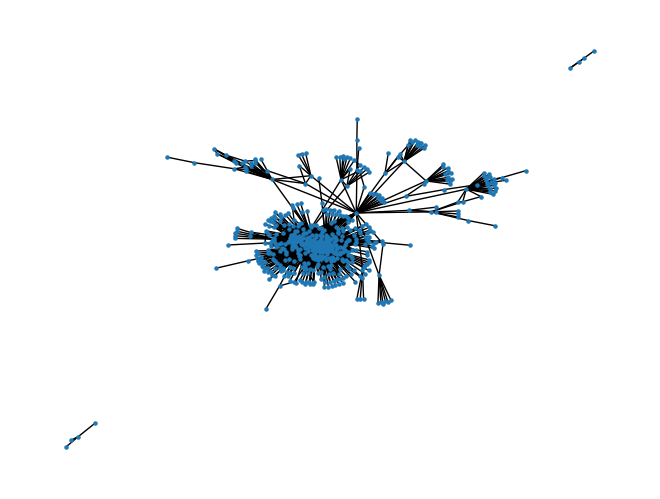

In [ ]:
g_routes_us_test = nx.Graph(((u, v, e) for u,v,e in g_routes.edges(data=True) if u in nodes_us and v in nodes_us))
nx.draw(g_routes_us_test,with_labels=False,node_size=5)
plt.show()

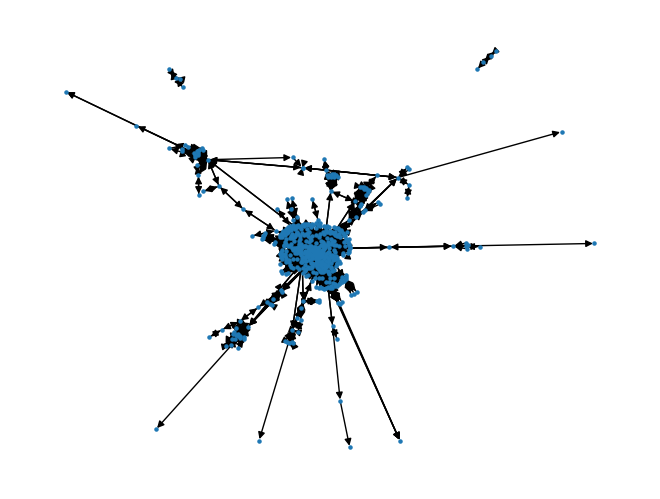

In [58]:
g_routes_us = g_routes.subgraph(nodes_us)
nx.draw(g_routes_us,with_labels=False,node_size=5)


In [70]:
# draw the graph on a map
# get the geo positions of the nodes
pos_us = {n: (v['longitude'],v['latitude']) for n,v in g_routes_us.nodes(data=True)}
# the node sizes will depend on the degree of the nodes
deg_us = nx.degree(g_routes_us)
sizes_us = [2*deg_us[n] for n in g_routes_us.nodes]
# We will display the labels of the largest airports only (at least 20 connections to other US airports):
labels_us = {n:n if deg_us[n]>= 50 else '' for n in g_routes_us.nodes}

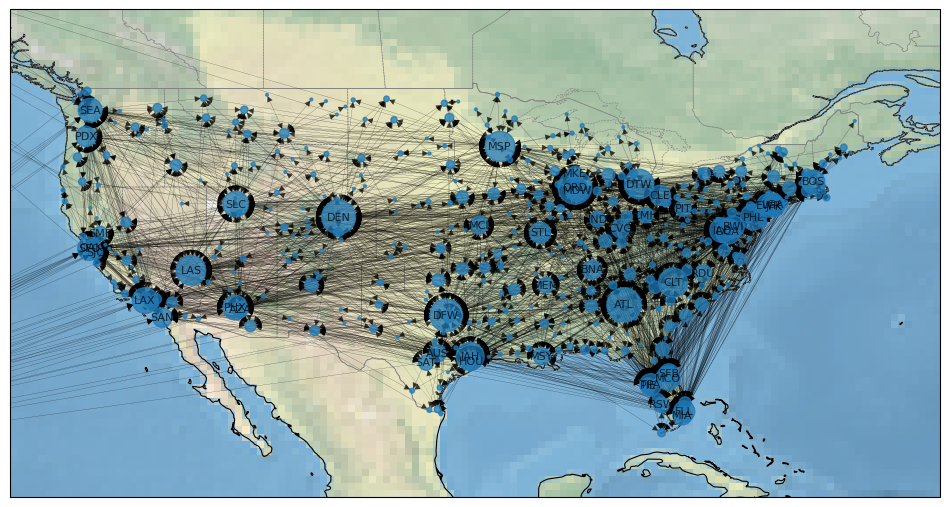

In [103]:
# Map projection
crs = ccrs.PlateCarree()
fig, ax = plt.subplots(
    1, 1, figsize=(12, 8),
    subplot_kw=dict(projection=crs))
# ax.coastlines()
# Extent of continental US.
ax.stock_img()
ax.set_extent([-128, -62, 20, 50])
# ax.add_feature(cfeature.OCEAN)
# ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE,edgecolor='black',linewidth=0.8)
ax.add_feature(cfeature.BORDERS,edgecolor='grey',linestyle='-',linewidth=0.6)
ax.add_feature(cfeature.STATES,edgecolor='grey',linestyle='--',linewidth=0.4)


nx.draw_networkx(g_routes_us, ax=ax,
                 font_size=8,
                 font_color = 'black',
                 alpha= 0.75,
                 width=.075,
                 node_size=sizes_us,
                 labels=labels_us,
                 pos=pos_us,
                #  node_color=altitude,
                 cmap=plt.cm.autumn)

## 3.TOP-DOWN APPROACH: COMPLEX NETWORK MODELS OF AIR TRANSPORT

whenever there is population needed, it is optional. We will first finish the analysis that require only the airline dataset.

### A. Macroscopic Network Properties

#### 1) Previous Studies (assignee to be decided)

#### 2) Case Study: Global Air Transport Network in 2014: Centrality Distributions: (Hongjie)

In [ ]:
g_routes

This is just a pic from the paper. Similar analysis should be done!!
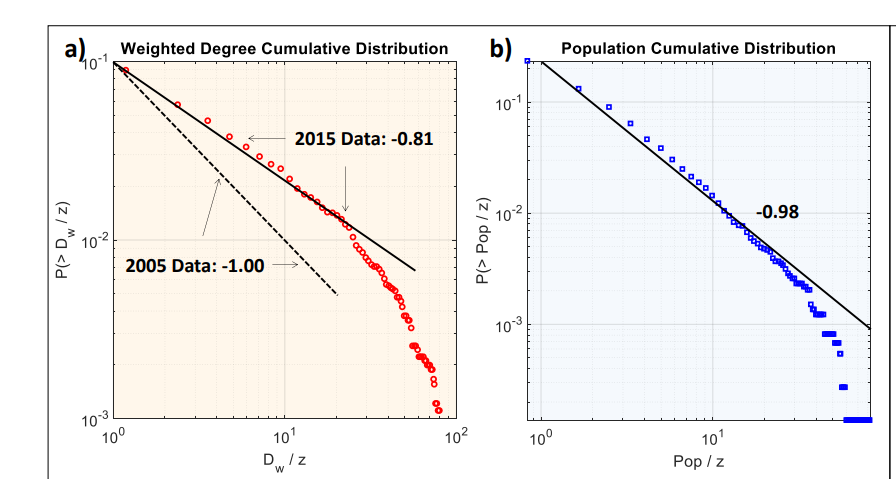

This is just a pic from the paper. Similar analysis should be done!!
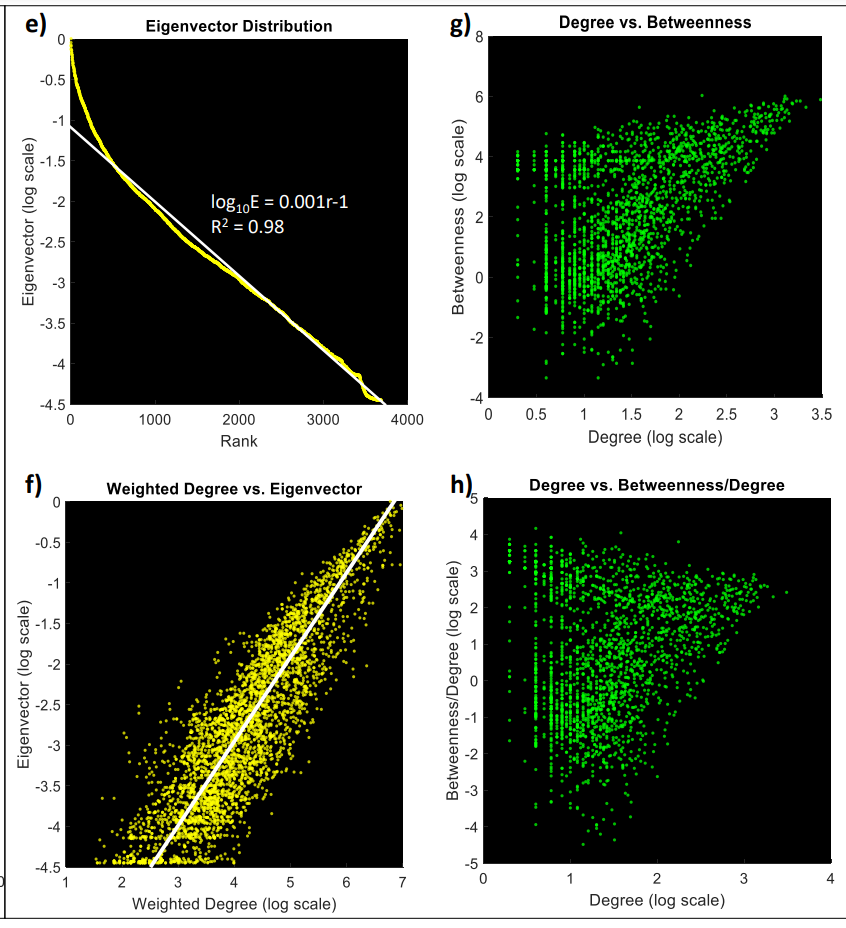

#### 3) Relation to Population Rank (optimal)

In [ ]:
df_airports.head()

This is just a pic from the paper. Similar analysis should be done!!
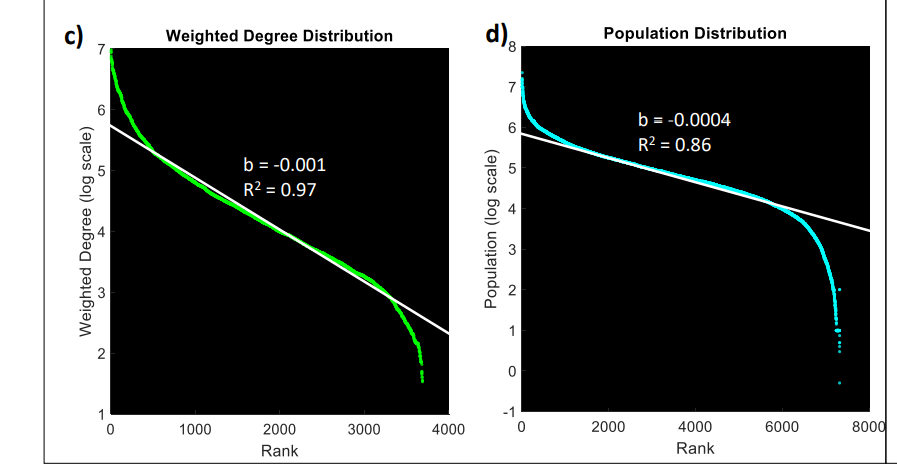

### B. Mesoscopic Network Properties

#### 1) Domestic Network Centrality and Relation to Wealth

This is just a pic from the paper. Similar analysis should be done!!
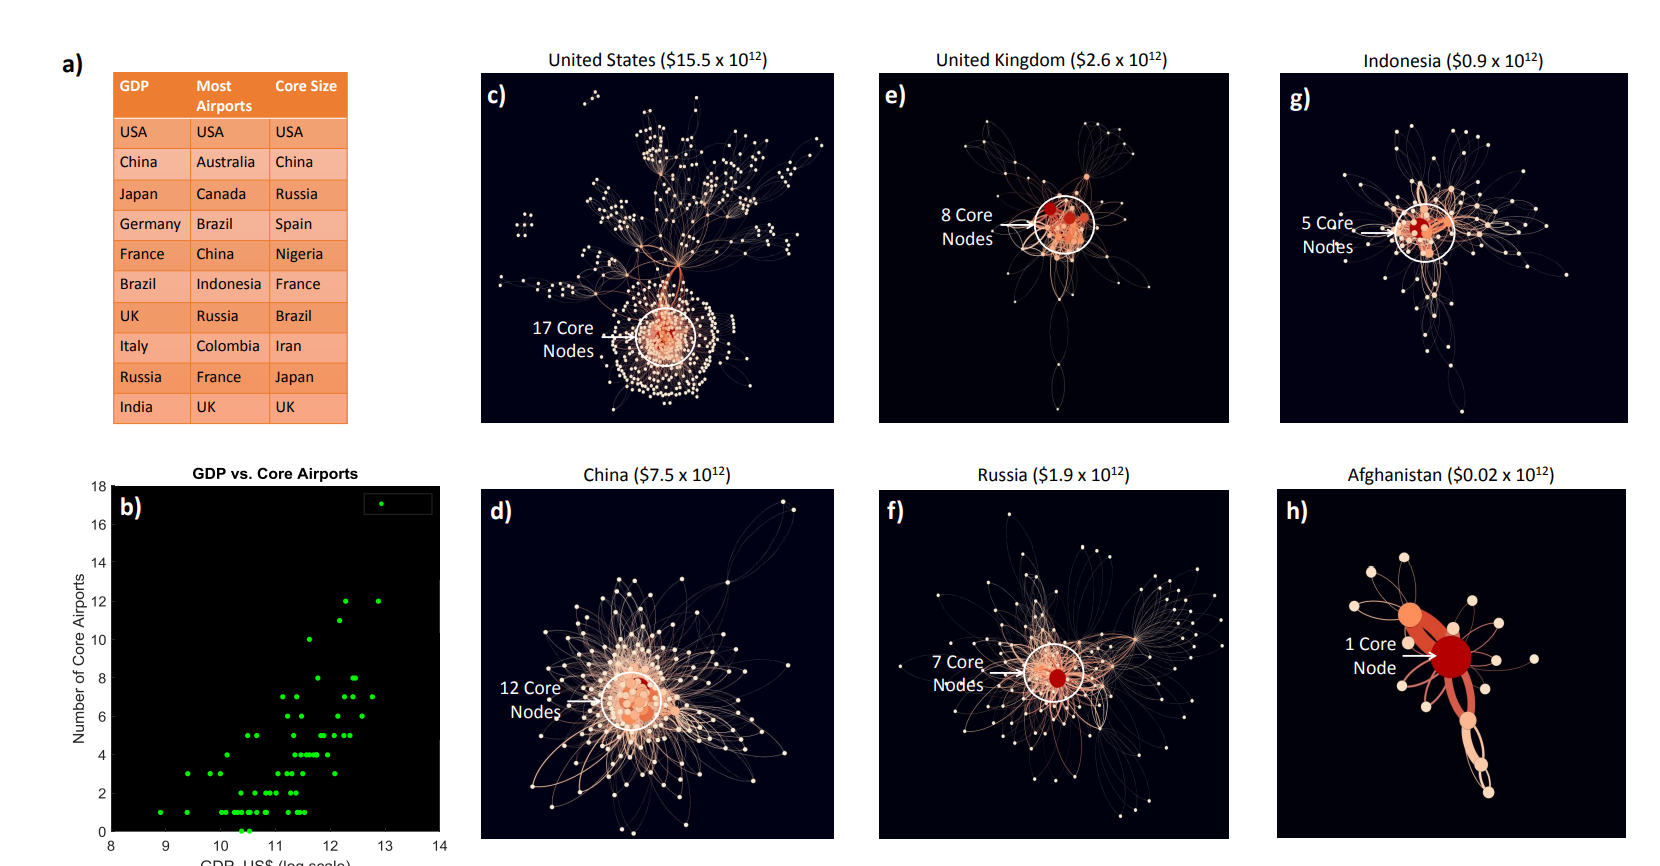

#### 2) Core-Periphery Structure (to be decided)

This is just a pic from the paper. Similar analysis should be done!!
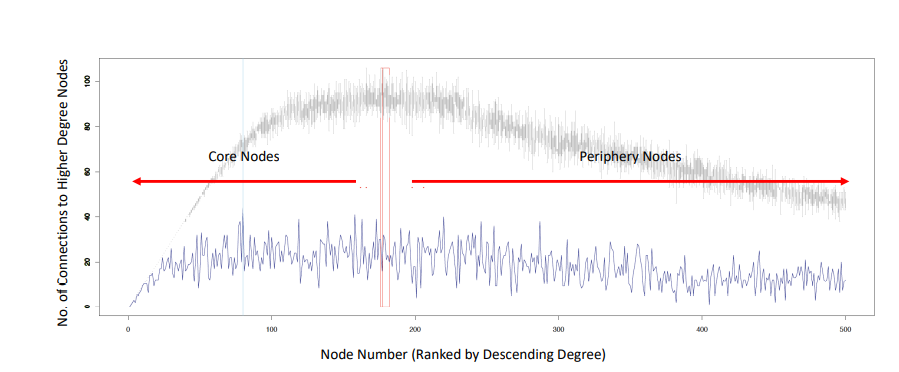

#### 3) Evolving Communities: (Jingting)

we will use the autralian data set because we need data of different time.

This is just a pic from the paper. Similar analysis should be done!!
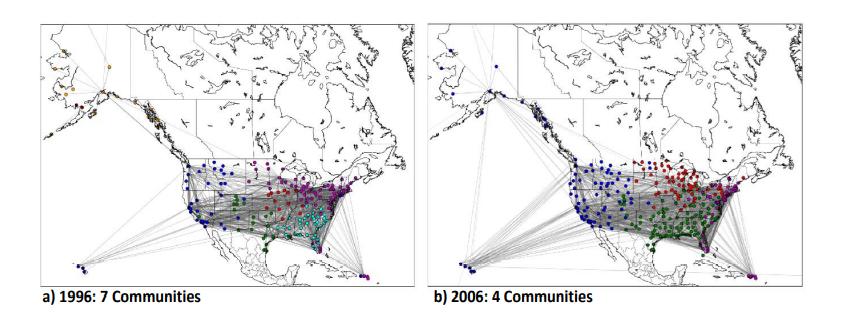

#### 4) Route Changes and Classification (Jingting)

This is just a pic from the paper. Similar analysis should be done!!

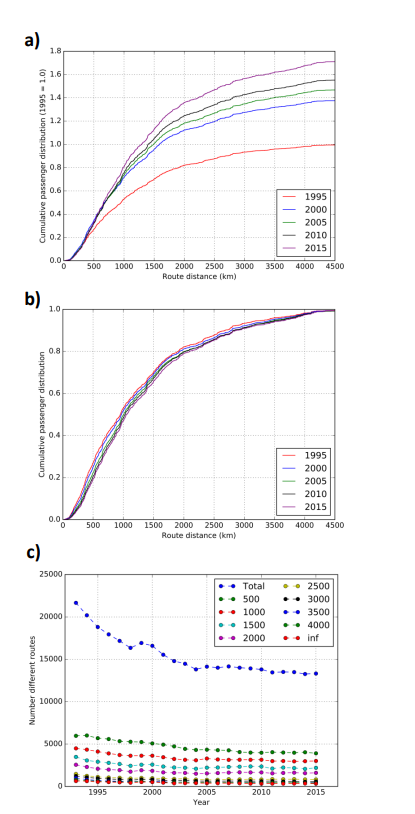

## IV. CONCLUSIONS